In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.models import resnet101
import matplotlib.pyplot as plt

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 256
EPOCHS = 20

print("Using device:", DEVICE)

Using device: cuda


# ***Helper Functions***

In [3]:
def load_dataset():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_dataset = datasets.SVHN('./data', split='train', download=True, transform=transform)
    test_dataset = datasets.SVHN('./data', split='test', download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)   
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return train_loader, test_loader

In [4]:
def get_optimizer(optim_name, model):
    if optim_name == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optim_name == 'adagrad':
        optimizer = optim.Adagrad(model.parameters(), lr=0.0001)
    elif optim_name == 'adadelta':
        optimizer = optim.Adadelta(model.parameters(), lr=0.001)
    elif optim_name == 'rmsprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)
    return optimizer

In [5]:
class ResNet101(nn.Module):
    def __init__(self):
        super(ResNet101, self).__init__()

        self.resnet = resnet101(weights='IMAGENET1K_V2')
        self.resnet.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.resnet(x)

In [6]:
def train(model, data_loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        running_acc += pred.eq(target.view_as(pred)).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100 * running_acc / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [7]:
def test(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            loss = criterion(output, target)

            running_loss += loss.item()

            _, top5_pred = output.topk(5, dim=1)  
            running_acc += top5_pred.eq(target.view(-1, 1).expand_as(top5_pred)).sum().item()  


    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = 100* running_acc / len(data_loader.dataset)

    return epoch_loss, epoch_acc

In [8]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs):
    best_test_acc = 0.0

    metrics = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }

    metric_best = {
        'train_loss': 0.0,
        'train_acc': 0.0,
        'test_loss': 0.0,
        'test_acc': 0.0
    }

    for epoch in range(epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        test_loss, test_acc = test(model, test_loader, criterion)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            metric_best['train_loss'] = train_loss
            metric_best['train_acc'] = train_acc
            metric_best['test_loss'] = test_loss
            metric_best['test_acc'] = test_acc

        metrics['train_loss'].append(train_loss)
        metrics['train_acc'].append(train_acc)
        metrics['test_loss'].append(test_loss)
        metrics['test_acc'].append(test_acc)

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Test Loss: {test_loss:.4f}, Test Acc (Top 5): {test_acc:.4f}\n')

    return metrics, metric_best      

In [9]:
def plot_metric(metrics):
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))
    ax[0].plot(metrics['train_loss'], label='Train Loss')
    ax[0].plot(metrics['test_loss'], label='Test Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(metrics['train_acc'], label='Train Acc')
    ax[1].plot(metrics['test_acc'], label='Test Acc (Top 5)')
    ax[1].set_title('Accuracy')
    ax[1].legend()

    plt.show()

In [10]:
def main(optimizer_name):
    train_loader, test_loader = load_dataset()

    model = ResNet101().to(DEVICE)

    optimizer = get_optimizer(optimizer_name, model)
    
    criterion = nn.CrossEntropyLoss()

    metrics, metric_best = train_model(model, train_loader, test_loader, optimizer, criterion, EPOCHS)
    plot_metric(metrics)

    print("BEST METRIC")
    print(f'Train Loss: {metric_best["train_loss"]:.4f}, Train Acc: {metric_best["train_acc"]:.4f}')
    print(f'Test Loss: {metric_best["test_loss"]:.4f}, Test Acc (Top 5): {metric_best["test_acc"]:.4f}')

# ***Experiments***

## ***Adam***

Using downloaded and verified file: ./data/train_32x32.mat


Using downloaded and verified file: ./data/test_32x32.mat


Epoch 1/20
Train Loss: 0.0021, Train Acc: 83.2617
Test Loss: 0.0011, Test Acc (Top 5): 99.1626



Epoch 2/20
Train Loss: 0.0009, Train Acc: 93.5528
Test Loss: 0.0010, Test Acc (Top 5): 99.1203



Epoch 3/20
Train Loss: 0.0007, Train Acc: 94.8346
Test Loss: 0.0011, Test Acc (Top 5): 98.8668



Epoch 4/20
Train Loss: 0.0007, Train Acc: 95.2223
Test Loss: 0.0009, Test Acc (Top 5): 99.1741



Epoch 5/20
Train Loss: 0.0005, Train Acc: 96.7334
Test Loss: 0.0010, Test Acc (Top 5): 99.1626



Epoch 6/20
Train Loss: 0.0004, Train Acc: 97.0474
Test Loss: 0.0010, Test Acc (Top 5): 99.1280



Epoch 7/20
Train Loss: 0.0004, Train Acc: 97.5893
Test Loss: 0.0010, Test Acc (Top 5): 99.1472



Epoch 8/20
Train Loss: 0.0003, Train Acc: 97.7750
Test Loss: 0.0010, Test Acc (Top 5): 99.1049



Epoch 9/20
Train Loss: 0.0003, Train Acc: 97.9224
Test Loss: 0.0010, Test Acc (Top 5): 99.0934



Epoch 10/20
Train Loss: 0.0003, Train Acc: 98.1695
Test Loss: 0.0010, Test Acc (Top 5): 99.1318



Epoch 11/20
Train Loss: 0.0002, Train Acc: 98.3087
Test Loss: 0.0010, Test Acc (Top 5): 99.1126



Epoch 12/20
Train Loss: 0.0002, Train Acc: 98.4643
Test Loss: 0.0011, Test Acc (Top 5): 99.0857



Epoch 13/20
Train Loss: 0.0002, Train Acc: 98.5421
Test Loss: 0.0012, Test Acc (Top 5): 99.0012



Epoch 14/20
Train Loss: 0.0002, Train Acc: 98.3865
Test Loss: 0.0012, Test Acc (Top 5): 99.1280



Epoch 15/20
Train Loss: 0.0002, Train Acc: 98.7073
Test Loss: 0.0011, Test Acc (Top 5): 99.1664



Epoch 16/20
Train Loss: 0.0001, Train Acc: 98.9134
Test Loss: 0.0013, Test Acc (Top 5): 98.7246



Epoch 17/20
Train Loss: 0.0002, Train Acc: 98.5831
Test Loss: 0.0012, Test Acc (Top 5): 99.1933



Epoch 18/20
Train Loss: 0.0004, Train Acc: 97.0993
Test Loss: 0.0011, Test Acc (Top 5): 99.0512



Epoch 19/20
Train Loss: 0.0002, Train Acc: 98.1845
Test Loss: 0.0011, Test Acc (Top 5): 99.1549



Epoch 20/20
Train Loss: 0.0001, Train Acc: 99.1973
Test Loss: 0.0012, Test Acc (Top 5): 99.1971



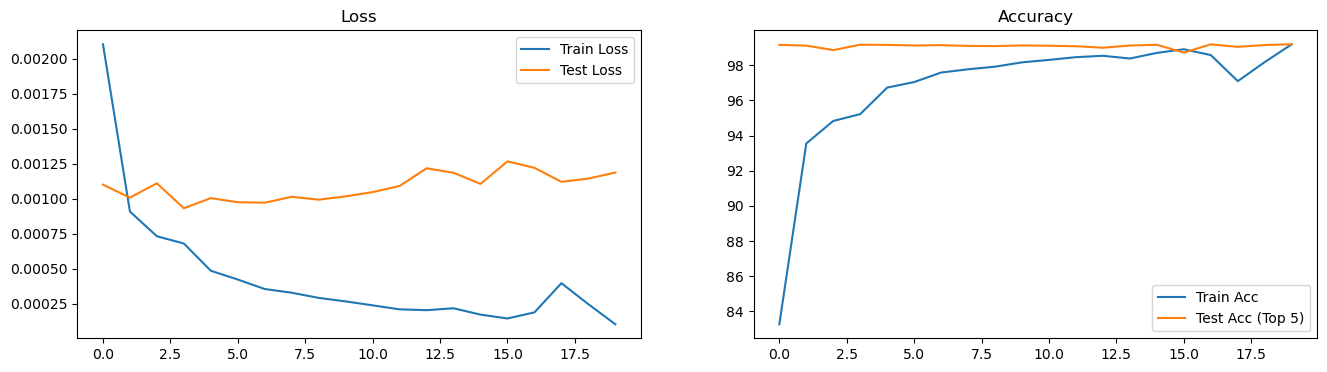

BEST METRIC
Train Loss: 0.0001, Train Acc: 99.1973
Test Loss: 0.0012, Test Acc (Top 5): 99.1971


In [11]:
main("adam")

## ***AdaDelta***

Using downloaded and verified file: ./data/train_32x32.mat


Using downloaded and verified file: ./data/test_32x32.mat


Epoch 1/20
Train Loss: 0.0090, Train Acc: 10.7676
Test Loss: 0.0090, Test Acc (Top 5): 56.9683



Epoch 2/20
Train Loss: 0.0089, Train Acc: 15.3255
Test Loss: 0.0089, Test Acc (Top 5): 61.8738



Epoch 3/20
Train Loss: 0.0088, Train Acc: 18.4924
Test Loss: 0.0088, Test Acc (Top 5): 64.1288



Epoch 4/20
Train Loss: 0.0087, Train Acc: 19.6869
Test Loss: 0.0089, Test Acc (Top 5): 65.7153



Epoch 5/20
Train Loss: 0.0086, Train Acc: 20.0868
Test Loss: 0.0089, Test Acc (Top 5): 66.7525



Epoch 6/20
Train Loss: 0.0085, Train Acc: 20.3052
Test Loss: 0.0089, Test Acc (Top 5): 67.6898



Epoch 7/20
Train Loss: 0.0084, Train Acc: 20.7134
Test Loss: 0.0087, Test Acc (Top 5): 68.2352



Epoch 8/20
Train Loss: 0.0084, Train Acc: 21.2703
Test Loss: 0.0086, Test Acc (Top 5): 68.6962



Epoch 9/20
Train Loss: 0.0083, Train Acc: 21.9720
Test Loss: 0.0084, Test Acc (Top 5): 69.0343



Epoch 10/20
Train Loss: 0.0082, Train Acc: 22.6477
Test Loss: 0.0084, Test Acc (Top 5): 69.4722



Epoch 11/20
Train Loss: 0.0081, Train Acc: 23.6646
Test Loss: 0.0082, Test Acc (Top 5): 69.9485



Epoch 12/20
Train Loss: 0.0080, Train Acc: 24.8686
Test Loss: 0.0081, Test Acc (Top 5): 70.5094



Epoch 13/20
Train Loss: 0.0079, Train Acc: 25.9115
Test Loss: 0.0083, Test Acc (Top 5): 70.9242



Epoch 14/20
Train Loss: 0.0079, Train Acc: 27.1701
Test Loss: 0.0083, Test Acc (Top 5): 71.2815



Epoch 15/20
Train Loss: 0.0078, Train Acc: 28.6717
Test Loss: 0.0079, Test Acc (Top 5): 71.8654



Epoch 16/20
Train Loss: 0.0077, Train Acc: 29.6163
Test Loss: 0.0080, Test Acc (Top 5): 72.5684



Epoch 17/20
Train Loss: 0.0076, Train Acc: 31.0278
Test Loss: 0.0081, Test Acc (Top 5): 73.3175



Epoch 18/20
Train Loss: 0.0075, Train Acc: 32.1689
Test Loss: 0.0084, Test Acc (Top 5): 74.0358



Epoch 19/20
Train Loss: 0.0074, Train Acc: 33.4303
Test Loss: 0.0083, Test Acc (Top 5): 74.9885



Epoch 20/20
Train Loss: 0.0072, Train Acc: 34.7612
Test Loss: 0.0076, Test Acc (Top 5): 76.4636



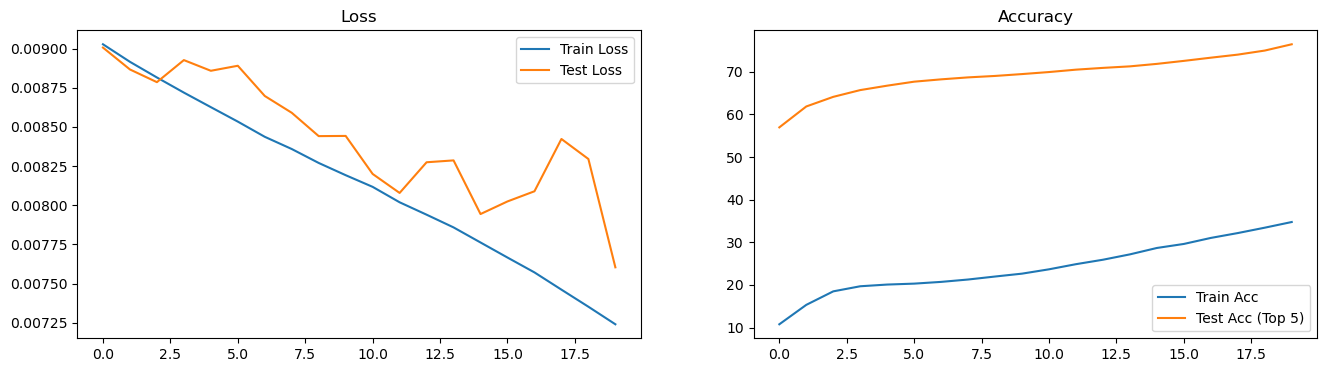

BEST METRIC
Train Loss: 0.0072, Train Acc: 34.7612
Test Loss: 0.0076, Test Acc (Top 5): 76.4636


In [12]:
main("adadelta")

## ***AdaGrad***

Using downloaded and verified file: ./data/train_32x32.mat


Using downloaded and verified file: ./data/test_32x32.mat


Epoch 1/20
Train Loss: 0.0084, Train Acc: 22.9685
Test Loss: 0.0081, Test Acc (Top 5): 72.1497



Epoch 2/20
Train Loss: 0.0076, Train Acc: 30.7547
Test Loss: 0.0082, Test Acc (Top 5): 76.9169



Epoch 3/20
Train Loss: 0.0071, Train Acc: 35.9911
Test Loss: 0.0077, Test Acc (Top 5): 81.3115



Epoch 4/20
Train Loss: 0.0066, Train Acc: 40.9080
Test Loss: 0.0083, Test Acc (Top 5): 84.2194



Epoch 5/20
Train Loss: 0.0062, Train Acc: 45.3090
Test Loss: 0.0083, Test Acc (Top 5): 86.8892



Epoch 6/20
Train Loss: 0.0058, Train Acc: 48.9646
Test Loss: 0.0082, Test Acc (Top 5): 88.4219



Epoch 7/20
Train Loss: 0.0055, Train Acc: 51.8995
Test Loss: 0.0070, Test Acc (Top 5): 89.4130



Epoch 8/20
Train Loss: 0.0052, Train Acc: 54.1709
Test Loss: 0.0079, Test Acc (Top 5): 90.5770



Epoch 9/20
Train Loss: 0.0049, Train Acc: 56.2458
Test Loss: 0.0073, Test Acc (Top 5): 91.1916



Epoch 10/20
Train Loss: 0.0047, Train Acc: 58.0886
Test Loss: 0.0087, Test Acc (Top 5): 91.3798



Epoch 11/20
Train Loss: 0.0045, Train Acc: 59.6694
Test Loss: 0.0075, Test Acc (Top 5): 92.2365



Epoch 12/20
Train Loss: 0.0043, Train Acc: 61.1041
Test Loss: 0.0068, Test Acc (Top 5): 92.6821



Epoch 13/20
Train Loss: 0.0042, Train Acc: 62.2876
Test Loss: 0.0070, Test Acc (Top 5): 92.9433



Epoch 14/20
Train Loss: 0.0040, Train Acc: 63.7700
Test Loss: 0.0058, Test Acc (Top 5): 93.3082



Epoch 15/20
Train Loss: 0.0039, Train Acc: 64.8184
Test Loss: 0.0081, Test Acc (Top 5): 93.2929



Epoch 16/20
Train Loss: 0.0038, Train Acc: 66.0087
Test Loss: 0.0072, Test Acc (Top 5): 93.2660



Epoch 17/20
Train Loss: 0.0037, Train Acc: 66.8291
Test Loss: 0.0057, Test Acc (Top 5): 94.0880



Epoch 18/20
Train Loss: 0.0036, Train Acc: 67.8188
Test Loss: 0.0064, Test Acc (Top 5): 94.2379



Epoch 19/20
Train Loss: 0.0035, Train Acc: 68.7743
Test Loss: 0.0071, Test Acc (Top 5): 94.2110



Epoch 20/20
Train Loss: 0.0034, Train Acc: 69.5074
Test Loss: 0.0049, Test Acc (Top 5): 94.6835



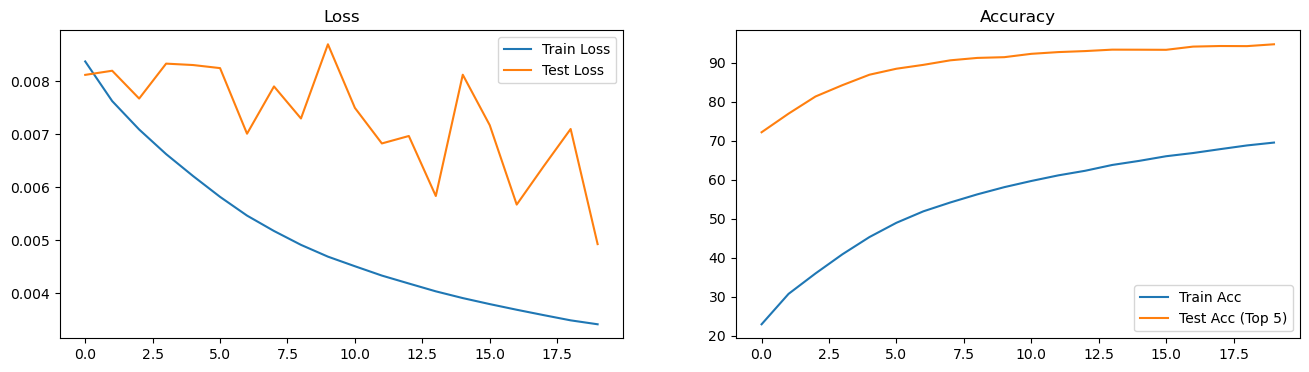

BEST METRIC
Train Loss: 0.0034, Train Acc: 69.5074
Test Loss: 0.0049, Test Acc (Top 5): 94.6835


In [13]:
main("adagrad")

## ***RMSProp***

Using downloaded and verified file: ./data/train_32x32.mat


Using downloaded and verified file: ./data/test_32x32.mat


Epoch 1/20
Train Loss: 0.0042, Train Acc: 62.8513
Test Loss: 0.0025, Test Acc (Top 5): 96.0587



Epoch 2/20
Train Loss: 0.0013, Train Acc: 90.9237
Test Loss: 0.0014, Test Acc (Top 5): 98.4365



Epoch 3/20
Train Loss: 0.0009, Train Acc: 93.3590
Test Loss: 0.0030, Test Acc (Top 5): 97.1650



Epoch 4/20
Train Loss: 0.0008, Train Acc: 94.5753
Test Loss: 0.0015, Test Acc (Top 5): 98.5864



Epoch 5/20
Train Loss: 0.0007, Train Acc: 95.4585
Test Loss: 0.0011, Test Acc (Top 5): 98.7439



Epoch 6/20
Train Loss: 0.0006, Train Acc: 96.3034
Test Loss: 0.0040, Test Acc (Top 5): 94.8256



Epoch 7/20
Train Loss: 0.0006, Train Acc: 96.4495
Test Loss: 0.0013, Test Acc (Top 5): 98.8168



Epoch 8/20
Train Loss: 0.0004, Train Acc: 97.3013
Test Loss: 0.0013, Test Acc (Top 5): 98.3636



Epoch 9/20
Train Loss: 0.0004, Train Acc: 97.6193
Test Loss: 0.0010, Test Acc (Top 5): 99.0550



Epoch 10/20
Train Loss: 0.0003, Train Acc: 97.8241
Test Loss: 0.0013, Test Acc (Top 5): 98.4750



Epoch 11/20
Train Loss: 0.0003, Train Acc: 98.0207
Test Loss: 0.0015, Test Acc (Top 5): 98.7054



Epoch 12/20
Train Loss: 0.0003, Train Acc: 98.2295
Test Loss: 0.0020, Test Acc (Top 5): 98.2906



Epoch 13/20
Train Loss: 0.0002, Train Acc: 98.3142
Test Loss: 0.0011, Test Acc (Top 5): 98.9590



Epoch 14/20
Train Loss: 0.0002, Train Acc: 98.5326
Test Loss: 0.0013, Test Acc (Top 5): 98.6901



Epoch 15/20
Train Loss: 0.0002, Train Acc: 98.5489
Test Loss: 0.0028, Test Acc (Top 5): 98.0140



Epoch 16/20
Train Loss: 0.0002, Train Acc: 98.6199
Test Loss: 0.0027, Test Acc (Top 5): 97.1535



Epoch 17/20
Train Loss: 0.0002, Train Acc: 98.7796
Test Loss: 0.0022, Test Acc (Top 5): 98.1600



Epoch 18/20
Train Loss: 0.0004, Train Acc: 98.0739
Test Loss: 0.0012, Test Acc (Top 5): 98.9321



Epoch 19/20
Train Loss: 0.0002, Train Acc: 98.5626
Test Loss: 0.0013, Test Acc (Top 5): 98.9398



Epoch 20/20
Train Loss: 0.0001, Train Acc: 99.0308
Test Loss: 0.0018, Test Acc (Top 5): 98.7131



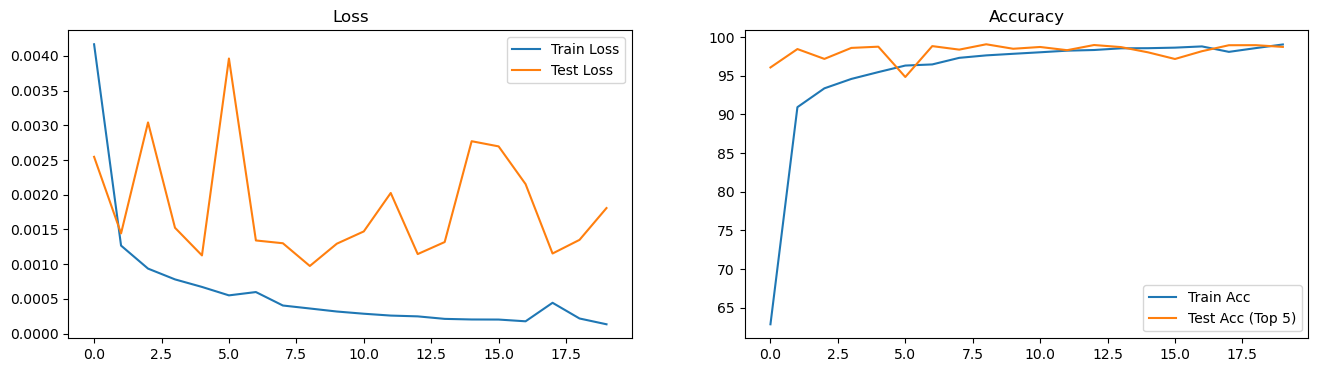

BEST METRIC
Train Loss: 0.0004, Train Acc: 97.6193
Test Loss: 0.0010, Test Acc (Top 5): 99.0550


In [14]:
main("rmsprop")